<a href="https://colab.research.google.com/github/Charlotte-99/Classifying_Cosmological_Data/blob/main/CategorisingOmegaB_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating a CNN designed to identify images of CMBs generated with different values for the cosmological parameter $\Omega_b$**

Importing the appropriate modules / set up TensorFlow environment to work in

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.python.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, AveragePooling2D, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split
from google.colab import files

In [ ]:
print(tf.__version__)

2.4.1


Importing the generated data files and formatting the data into appropriate data sets for use in a CNN

In [ ]:
# Import the sky maps created previously
uploaded = files.upload()

Saving training_data_all.npz to training_data_all.npz


In [ ]:
# Load file and merge data with a channel dimension
training_data = np.load('training_data_all.npz')

X_input = np.concatenate([training_data['data_0_0175'],
                          training_data['data_0_02'],
                          training_data['data_0_0226'],
                          training_data['data_0_025'],
                          training_data['data_0_0275']]).astype(np.float32)[...,np.newaxis]

In [ ]:
# Label data
# 0 - 0.0175
# 1 - 0.02
# 2 - 0.0226
# 3 - 0.025
# 4 - 0.0275
y_input = np.concatenate([np.zeros(100), np.ones(100), np.ones(100)*2,
                          np.ones(100)*3, np.ones(100)*4])

In [ ]:
# Shuffle data and split into test and train sets
np.random.RandomState(7).shuffle(X_input)
np.random.RandomState(7).shuffle(y_input)

X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.33,
                                                    random_state=7)

In [ ]:
# Normalise data
min = np.min(X_input)
max = np.max(X_input)
X_train = (X_train - min)/(max - min)
X_test = (X_test - min)/(max - min)

Building a CNN and processing data through the network

In [ ]:
# Function to define the layers of the CNN
def build_model():
  model = Sequential()
  model.add(Conv2D(64, 3, activation='relu', input_shape=(96,96,1)))
  model.add(Flatten())
  model.add(Dense(250, activation='relu'))
  model.add(Dense(250, activation='relu'))
  model.add(Dense(5, activation = 'softmax'))
  model.summary()

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
# Calling the function to build, train and test the model
model = build_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1, 
                    validation_data=(X_test, y_test), callbacks=[callback])

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 64)        640       
_________________________________________________________________
flatten_1 (Flatten)          (None, 565504)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               141376250 
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1255      
Total params: 141,440,895
Trainable params: 141,440,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
21/21 [==============================] - 33s 2s/step - loss: 7.7721 - accuracy: 0.1625 - val_lo

Plotting the test and train loss vs epoch to see how the model has developed

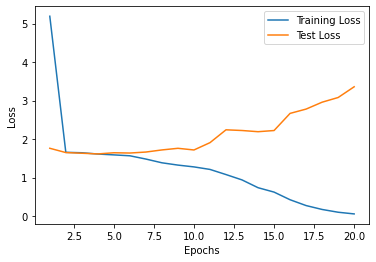

In [ ]:
loss_values = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()